### Binary classification about company bankruptcys in Taiwan
(not very well distributed)

In [10]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import sys
sys.path.append("..")
from bpitnorm.modules.BatchPitNormalization import BatchPitNorm1d

device = "cuda" if torch.cuda.is_available() else "cpu"

data = np.genfromtxt("../Data/taiwaneseBankruptcyPred.csv", delimiter=",", skip_header=1)
data = data[~(np.isnan(data)).any(axis=1)]
data = data[~(np.isinf(data)).any(axis=1)]
print("Number of features: ", data.shape[1])
print("Number of datapoints: ", data.shape[0])

def data_split(data):
  X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data[:, 1:], data[:, 0], test_size=0.2)
  y_train_raw = y_train_raw.reshape(-1, 1)
  y_test_raw = y_test_raw.reshape(-1, 1)

  scaler1 = StandardScaler()
  scaler_x = scaler1.fit(X_train_raw)
  X_train = scaler_x.transform(X_train_raw)
  X_test = scaler_x.transform(X_test_raw)

  scaler2 = StandardScaler()
  scaler_y = scaler2.fit(y_train_raw)

  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
  y_train = torch.tensor(y_train_raw, dtype=torch.float32, device=device).reshape(-1, 1)
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device=device)
  y_test = torch.tensor(y_test_raw, dtype=torch.float32, device=device).reshape(-1, 1)
  return X_train, y_train, X_test, y_test, scaler_y

Number of features:  96
Number of datapoints:  6819


In [11]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, loops):
    model.to(device=device)
    acc_lst = np.zeros(loops)
    f1_lst = np.zeros(loops)

    for i in range(loops):
        X_train, y_train, X_test, y_test, scaler_y = data_split(data)
        loss_fn = nn.BCEWithLogitsLoss().to(device=device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=150, shuffle=True)
        n_epochs = 30
        for epoch in range(n_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward(retain_graph=True)
                optimizer.step()
                optimizer.zero_grad()
        model.eval()
        y_pred = model(X_test)
        y_pred_prob = torch.sigmoid(y_pred)
        y_pred_binary = (y_pred_prob > 0.5).float().cpu().detach()
        acc = accuracy_score(y_test.cpu(), y_pred_binary)
        acc_lst[i] = float(acc)
        f1 = f1_score(y_test.cpu(), y_pred_binary)
        f1_lst[i] = float(f1)
        print("Accuracy:", float(acc))
        print("F1-score:", float(f1))
    return acc_lst, f1_lst

Accuracy: 0.9582111436950147
F1-score: 0.2191780821917808
Accuracy: 0.9780058651026393
F1-score: 0.6153846153846154
Accuracy: 0.9860703812316716
F1-score: 0.7323943661971831


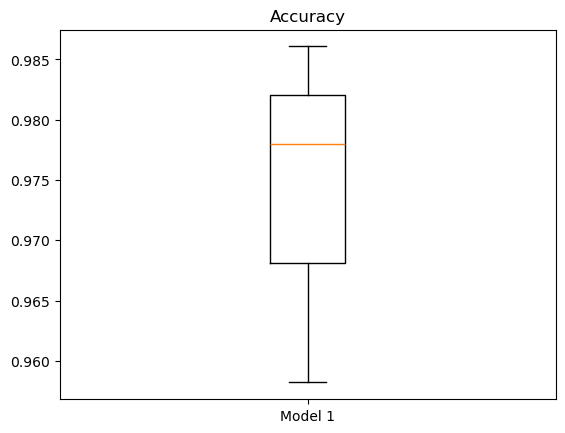

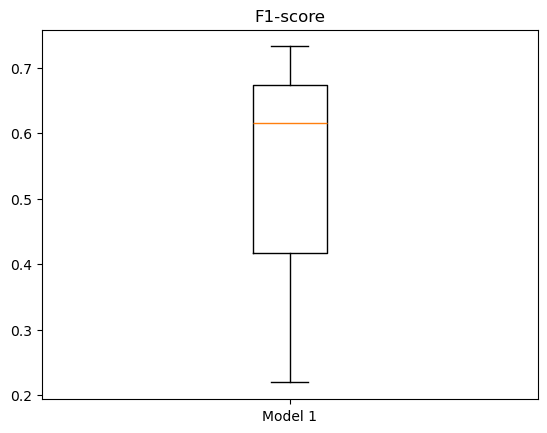

In [12]:
model1 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(10, 1))
model1.to(device=device)

acc1, f1_1 = train_model(model1, 3)
plt.boxplot(acc1, labels=["Model 1"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_1, labels=["Model 1"])
plt.title("F1-score")
plt.show()

Accuracy: 0.9640762463343109
F1-score: 0.2898550724637681
Accuracy: 0.9699413489736071
F1-score: 0.5176470588235295
Accuracy: 0.9838709677419355
F1-score: 0.6764705882352942


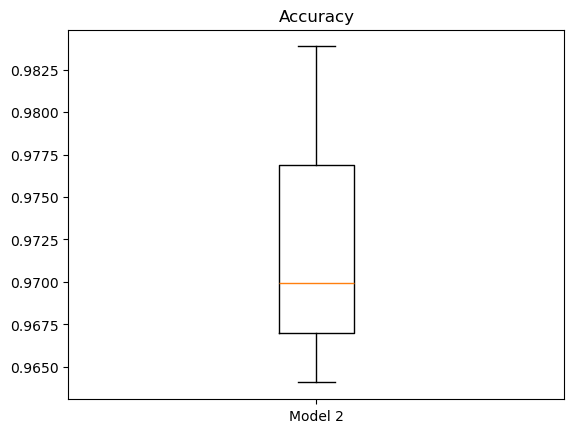

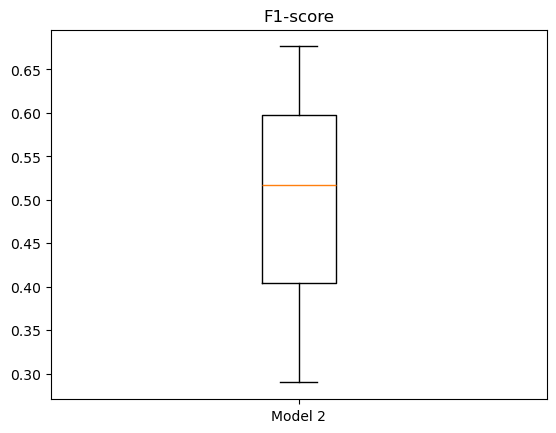

In [13]:
model2 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
model2.to(device=device)

acc2, f1_2 = train_model(model2, 3)
plt.boxplot(acc2, labels=["Model 2"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_2, labels=["Model 2"])
plt.title("F1-score")
plt.show()

Accuracy: 0.9545454545454546
F1-score: 0.32608695652173914
Accuracy: 0.9728739002932552
F1-score: 0.39344262295081966
Accuracy: 0.9816715542521994
F1-score: 0.691358024691358


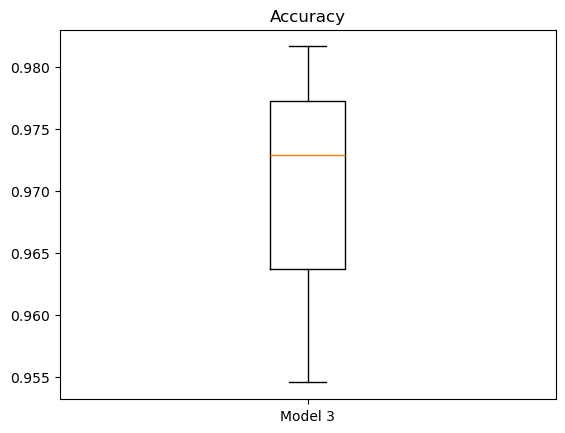

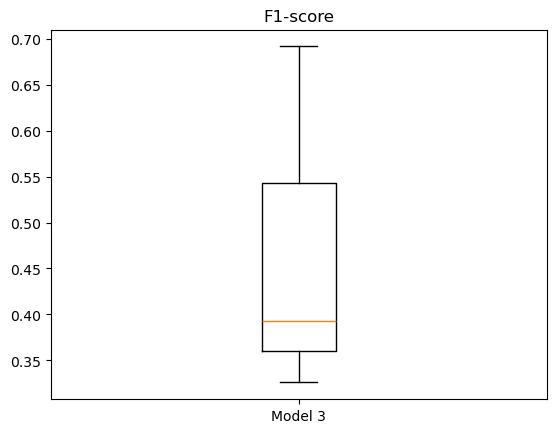

In [14]:
model3 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 30),
    BatchPitNorm1d(num_features=30, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.ReLU(),
    nn.Linear(30, 80),
    nn.ReLU(),
    nn.Linear(80, 100),
    nn.ReLU(),
    nn.Linear(100, 1))
model3.to(device=device)

acc3, f1_3 = train_model(model3, 3)
plt.boxplot(acc3, labels=["Model 3"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_3, labels=["Model 3"])
plt.title("F1-score")
plt.show()

Accuracy: 0.9699413489736071
F1-score: 0.0
Accuracy: 0.9706744868035191
F1-score: 0.2
Accuracy: 0.9567448680351907
F1-score: 0.3917525773195876


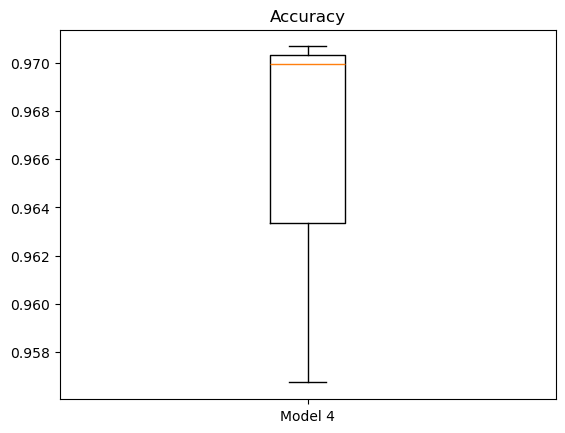

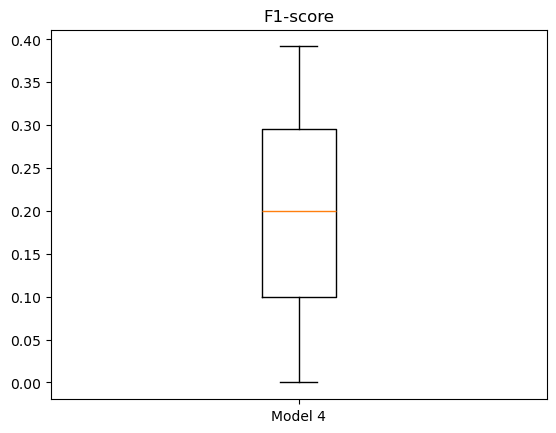

In [15]:
model4 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    BatchPitNorm1d(num_features=10, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.ReLU(),
    nn.Linear(10, 1))
model4.to(device=device)

acc4, f1_4 = train_model(model4, 3)
plt.boxplot(acc4, labels=["Model 4"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_4, labels=["Model 4"])
plt.title("F1-score")
plt.show()

Accuracy: 0.9721407624633431
F1-score: 0.45714285714285713
Accuracy: 0.9655425219941349
F1-score: 0.37333333333333335
Accuracy: 0.9787390029325513
F1-score: 0.6027397260273972


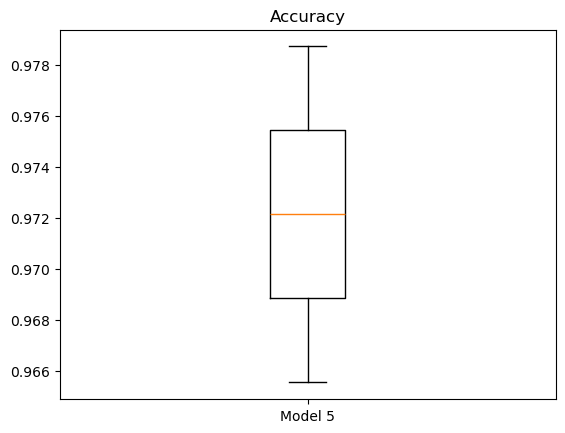

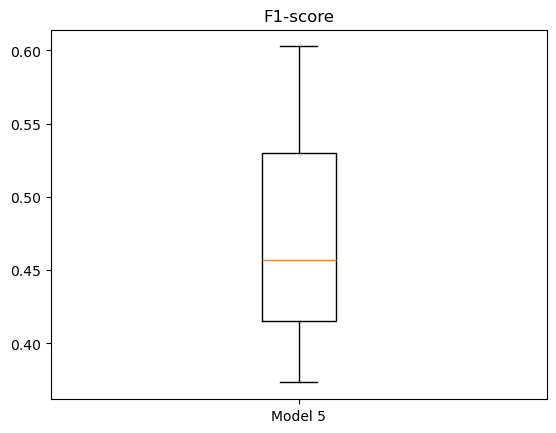

In [16]:
model5 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 10),
    BatchPitNorm1d(num_features=10, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.ReLU(),
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.BatchNorm1d(50),
    nn.Linear(50, 70),
    nn.ReLU(),
    nn.Linear(70, 1))
model5.to(device=device)

acc5, f1_5 = train_model(model5, 3)
plt.boxplot(acc5, labels=["Model 5"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_5, labels=["Model 5"])
plt.title("F1-score")
plt.show()

Accuracy: 0.967008797653959
F1-score: 0.1509433962264151
Accuracy: 0.9567448680351907
F1-score: 0.3218390804597701
Accuracy: 0.9728739002932552
F1-score: 0.5066666666666667


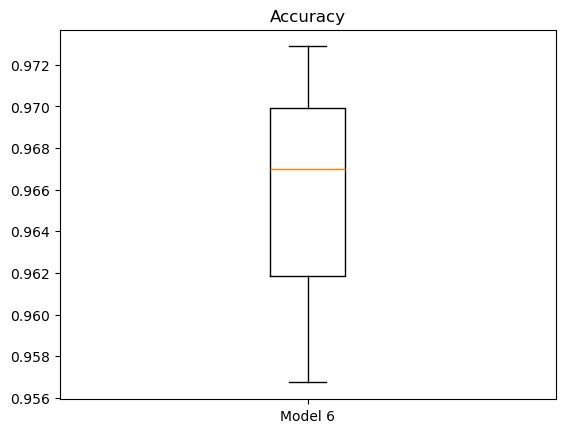

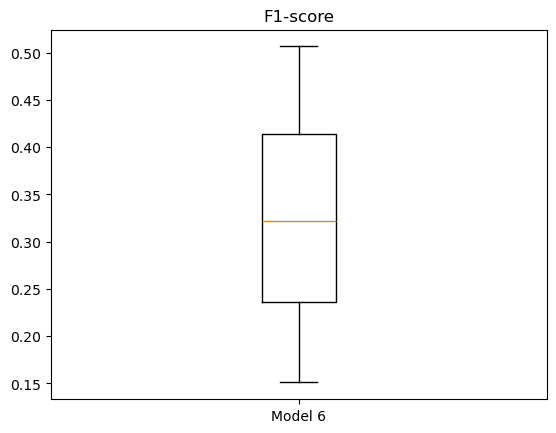

In [17]:
model6 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    BatchPitNorm1d(num_features=50, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
model6.to(device=device)

acc6, f1_6 = train_model(model6, 3)
plt.boxplot(acc6, labels=["Model 6"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_6, labels=["Model 6"])
plt.title("F1-score")
plt.show()

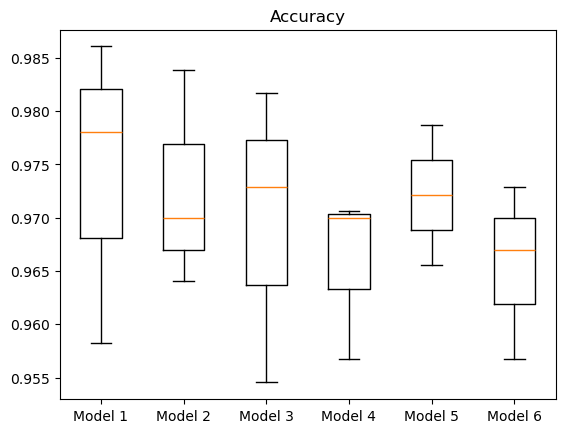

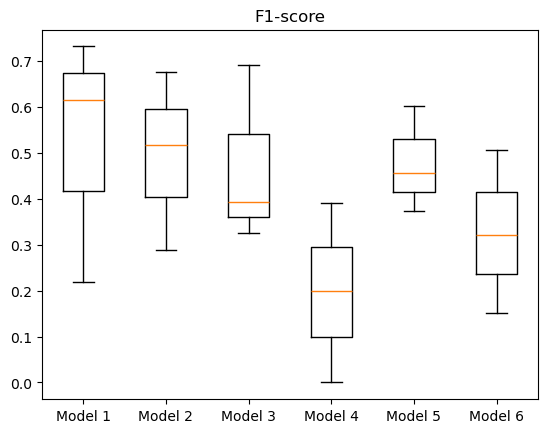

In [18]:
plt.boxplot([acc1, acc2, acc3, acc4, acc5, acc6], labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"])
plt.title("Accuracy")
plt.show()

plt.boxplot([f1_1, f1_2, f1_3, f1_4, f1_5, f1_6], labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"])
plt.title("F1-score")
plt.show()

num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=True
Accuracy: 0.9743401759530792
F1-score: 0.4927536231884058
Accuracy: 0.9699413489736071
F1-score: 0.5176470588235295
Accuracy: 0.9824046920821115
F1-score: 0.6842105263157895
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=False
Accuracy: 0.9626099706744868
F1-score: 0.37037037037037035
Accuracy: 0.967741935483871
F1-score: 0.4634146341463415
Accuracy: 0.9736070381231672
F1-score: 0.5813953488372093
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=True
Accuracy: 0.9640762463343109
F1-score: 0.3287671232876712
Accuracy: 0.9699413489736071
F1-score: 0.4533333333333333
Accuracy: 0.9824046920821115
F1-score: 0.7142857142857143
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=False
Accuracy: 0.9567448680351907
F1-score: 0.3516483516483517
Accu

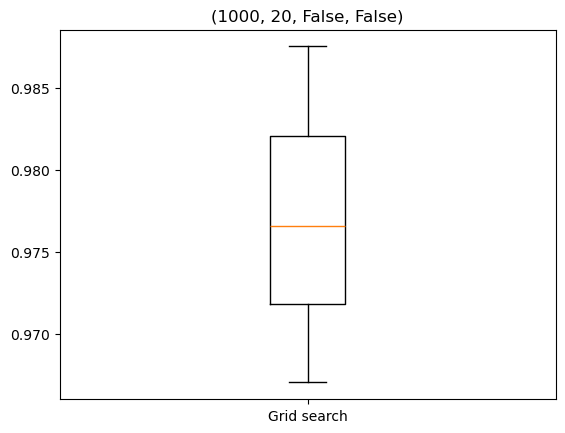

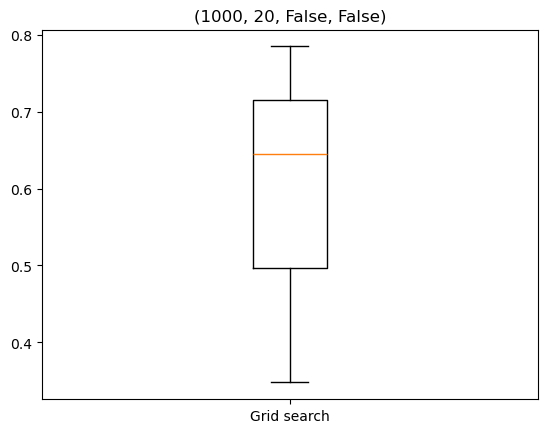

Best params: (250, 0, True, False) with accuracy: 0.97702834799609, F1-score: 0.5923602193277482


In [19]:
from itertools import product


param_grid = {
  'num_pit_samples': [50, 100, 150, 250, 500, 1000],
  'take_num_samples_when_full': [0, 1, 2, 3, 5, 10, 20],
  'normal_backtransform': [True, False],
  'trainable_bandwidths': [True, False]
}

best_f1_g = -np.inf
best_params = None

for params in product(*param_grid.values()):
  num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths = params
  print(f"num_pit_samples={num_pit_samples}, take_num_samples_when_full={take_num_samples_when_full},"+
        f" normal_backtransform={normal_backtransform}, trainable_bandwidths={trainable_bandwidths}")

  # Same as model 3
  model_g = nn.Sequential(
    nn.Linear(data.shape[1]-1, 30),
    BatchPitNorm1d(num_features=30, num_pit_samples=num_pit_samples, take_num_samples_when_full=take_num_samples_when_full,
                    normal_backtransform=normal_backtransform, trainable_bandwidths=trainable_bandwidths, dev=device),
    nn.ReLU(),
    nn.Linear(30, 80),
    nn.ReLU(),
    nn.Linear(80, 100),
    nn.ReLU(),
    nn.Linear(100, 1))
  model_g.to(device=device)
  acc_g, f1_g = train_model(model_g, 3)
  
  if np.mean(f1_g) > np.mean(best_f1_g):
    best_acc_g = acc_g
    best_f1_g = f1_g
    best_params = params

plt.boxplot(best_acc_g, labels=["Grid search"])
plt.title(best_params)
plt.show()

plt.boxplot(best_f1_g, labels=["Grid search"])
plt.title(best_params)
plt.show()

print(f"Best params: {best_params} with accuracy: {np.mean(best_acc_g)}, F1-score: {np.mean(best_f1_g)}")


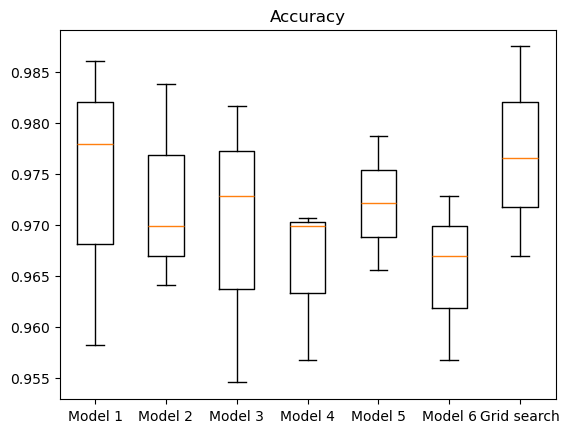

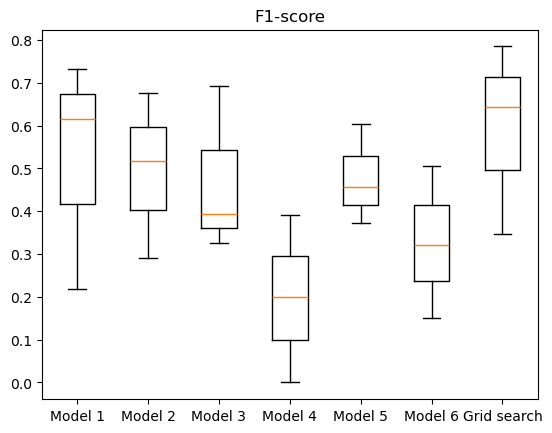

In [20]:
plt.boxplot([acc1, acc2, acc3, acc4, acc5, acc6, best_acc_g], labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6", "Grid search"])
plt.title("Accuracy")
plt.show()

plt.boxplot([f1_1, f1_2, f1_3, f1_4, f1_5, f1_6, best_f1_g], labels=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6", "Grid search"])
plt.title("F1-score")
plt.show()

Model 1: Without any batch layer 

Model 2: With ordinary batch normalization layer.

Model 3: With batch pit normalization layer.

Model 4: With batch pit normalization layer.

Model 5: With both ordinary batch and batch pit normalization layer.

Model 6: With both ordinary batch and batch pit normalization layer.

This dataset is not well distributed which makes it easy to get a high accuracy but hard to get high F1-score. I would say that the grid search model still is the best with F1-score around $0.63$ and accuracy around $0.976$. The accuracy is very good but I would not consider the model to be skillful according to the F1-score.